<div>
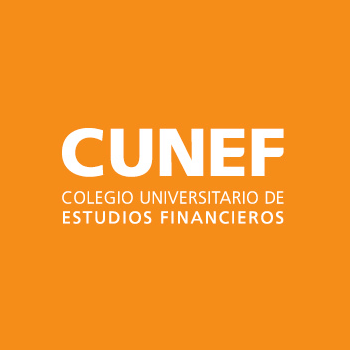
</div>


# **Apple Inc.**

En este notebook se mostrará la serie temporal del **ventas trimestrales de Apple** y observaremos cómo le afectó frente al COVID-19.


Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura, preprocesado e intervención del momento COVID-19
    3) EDA (Análisis Exploratorio de Datos)
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
        4.4) Comparativa errores y elección del mejor modelo
    5) Predicción hasta finales de año 

## *1) Librerías utilizadas*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *2) Lectura del archivo y preprocesado de los datos*
Se procede a leer el archivo CSV de las ventas trimestrales de Apple.

- Fuente: https://www.macrotrends.net/stocks/charts/AAPL/apple/revenue#:~:text=Apple%20annual%20revenue%20for%202021,a%202.04%25%20decline%20from%202018.

In [2]:
df_aapl=pd.read_csv("aapl.csv", sep=';',decimal=',')
df_aapl

,Periodo,Ingresos
0,1995T1,2652
1,1995T2,2575
2,1995T3,3003
3,1995T4,3148
4,1996T1,2185
...,...,...
105,2021T2,81434
106,2021T3,83360
107,2021T4,123945
108,2022T1,97278


Los datos están en trimestres, vamos a pasarlos a meses:

In [3]:
df_aapl['Periodo'] = df_aapl['Periodo'].str.replace('T', 'Q')
df_aapl['Periodo'] = pd.to_datetime(df_aapl['Periodo'].str.replace(r'(Q\d) (\d+)', r'\2-\1'), errors= 'coerce')
df_aapl.head()

,Periodo,Ingresos
0,1995-01-01,2652
1,1995-04-01,2575
2,1995-07-01,3003
3,1995-10-01,3148
4,1996-01-01,2185


In [4]:
# convert to period
df_aapl['Periodo']=pd.to_datetime(df_aapl['Periodo']).dt.to_period('M')
df_aapl=df_aapl.set_index('Periodo').resample('M').interpolate()
df_aapl.tail()

,Ingresos
Periodo,
2021-12,106167.0
2022-01,97278.0
2022-02,92505.0
2022-03,87732.0
2022-04,82959.0


Por último, observamos si hay algún valor nulo o faltante para poder realizar posteriormente los gráficos de las componentes estacionales:

In [5]:
df_aapl.isnull().sum()

Ingresos    0
dtype: int64

## *3) EDA*
Para realizar los plots, recurriremos a los que nos ofrece la librería Seaborn:

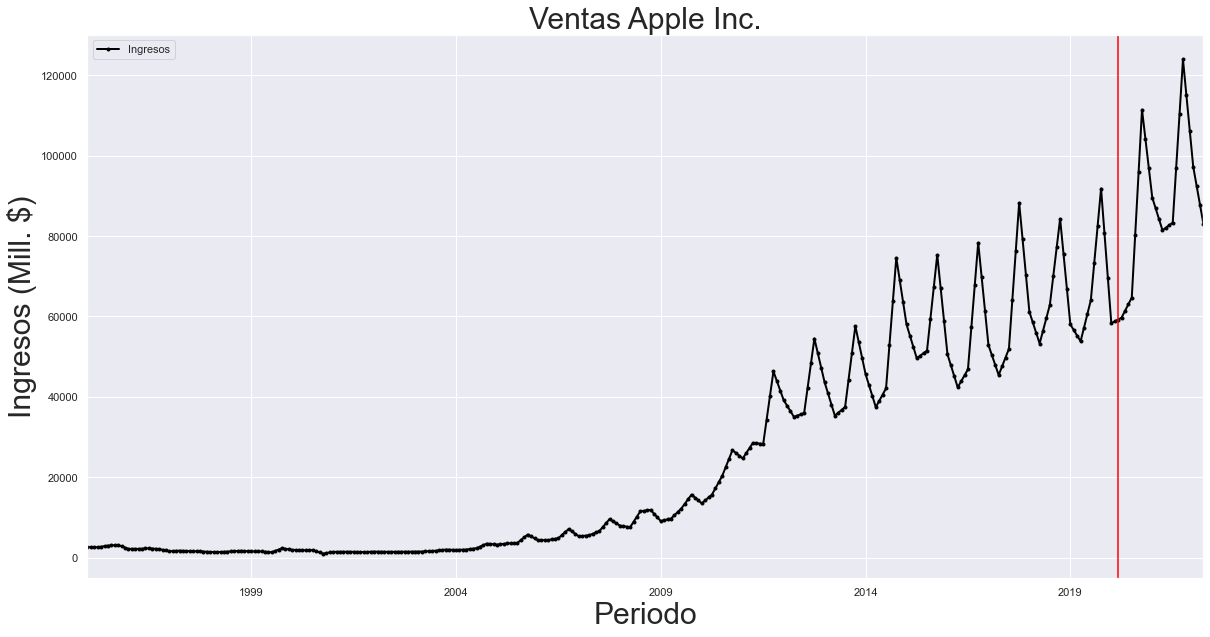

In [6]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_aapl.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Ventas Apple Inc.', fontsize = 30) 
fig.set_ylabel('Ingresos (Mill. $)', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30);

Podemos observar que las ventas de Apple presentan una clara tendencia positiva. Tiene un componente estacional puesto que las ventas dependen del trimestre. No parece que le haya afectado el periodo COVID-19. 

A continuación, analizaremos la estacionalidad y comprobaremos si la serie temporal es estacionaria mediante:
- Cálculo de la media y de la varianza
- Test de Dickey-Fuller aumentada
- Gráficas de comportamiento mensual
- Descomposición

### 3.1) Cálculo de la media y de la varianza

Acortamos primero la serie para mejorar el estudio:

In [7]:
df_aapl=df_aapl.iloc[168:,] #56 datos que suprimimos del dataset * 3 del trimestre que hemos manipulado antes
df_aapl.head()

,Ingresos
Periodo,
2009-01,9084.000000
2009-02,9300.666667
2009-03,9517.333333
2009-04,9734.000000
2009-05,10558.333333


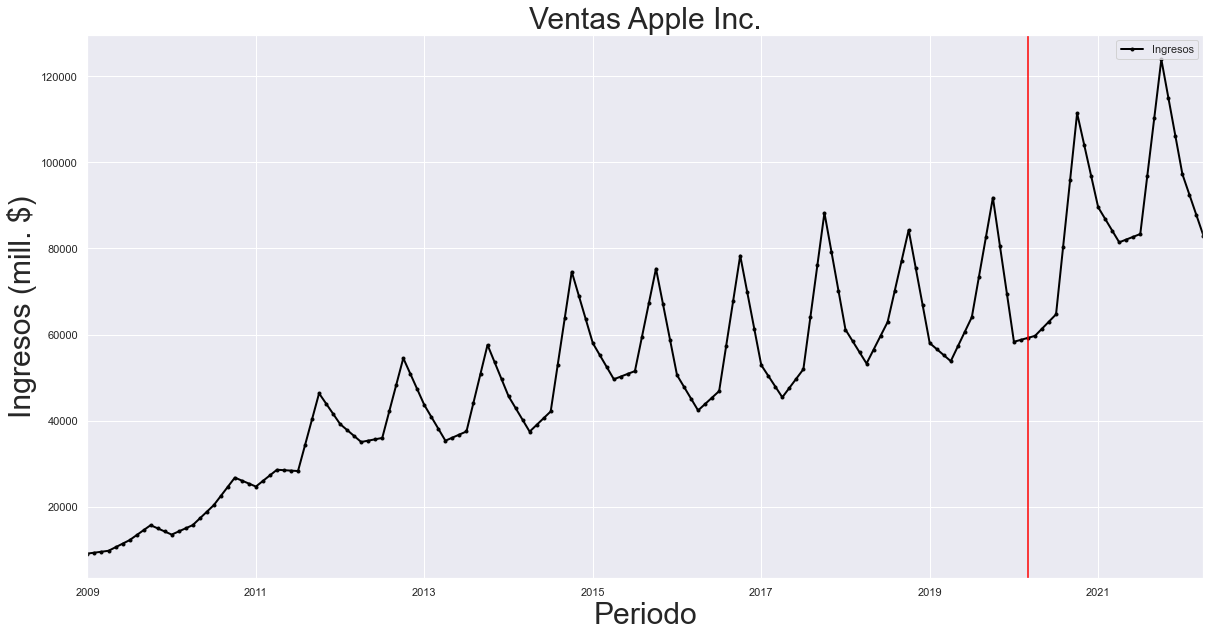

In [54]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_aapl.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Ventas Apple Inc.', fontsize = 30) 
fig.set_ylabel('Ingresos (mill. $)', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30)
# fig.figure.savefig('../pics/df_aapl/tendencia');

In [9]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

mean = split_and_summarize(df_aapl, 'Ingresos', 4, np.mean)
variance = split_and_summarize(df_aapl, 'Ingresos', 4, np.var)

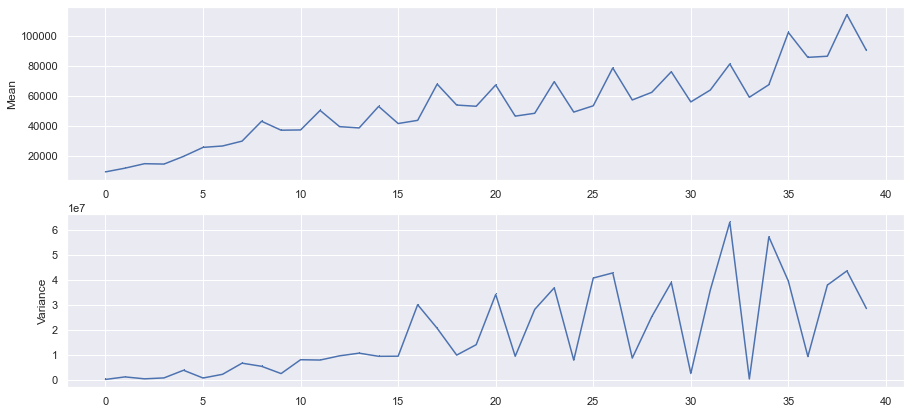

In [55]:
cols = ['mean', 'variance']
df = pd.DataFrame([mean, variance], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(mean, ',-')
ax1.set_ylabel('Mean')

ax2.plot(variance, ',-')
ax2.set_ylabel('Variance')

plt.show()
# fig.figure.savefig('../pics/df_aapl/meanvariance');

A simple vista se ve que ni la media ni la varianza tienen unos valores constantes en el tiempo, lo que nos indica que la serie no es estacionaria. Para asegurarnos al 100% realizaremos la prueba de Dickey-Fuller aumentada.


### 3.2. Test de Dickey-Fuller aumentada

Esta prueba nos proporciona una verificación rápida y evidente de si la serie es estacionaria o no.

**La hipótesis nula (H0)** de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria, es decir, que tiene alguna estructura dependiente del tiempo. 

**La hipótesis alternativa (H1)**, que rechaza la hipótesis nula, indica que la serie temporal es estacionaria.

Interpretamos este resultado utilizando el p-value. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza.

In [11]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_aapl['Ingresos'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.926123
p-value                          0.779248
#Lags Used                      10.000000
Number of Observations Used    149.000000
Critical Value (1%)             -3.475018
Critical Value (5%)             -2.881141
Critical Value (10%)            -2.577221
dtype: float64


**La serie temporal NO es estacionaria**, debido a que el p-value del test Dickey-Fuller (0.78) es mayor que 0.05, y eso indica que se acepta la hipótesis nula (H0).

Además, vemos que nuestro test estadístico (-0.92) es bastante mayor que los umbrales de significancia del 1%, 5% y 10%, lo que nos da más indicios de que es una serie que posee alguna estructura dependiente del tiempo.

### 3.3) Gráficas de comportamiento mensual
A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

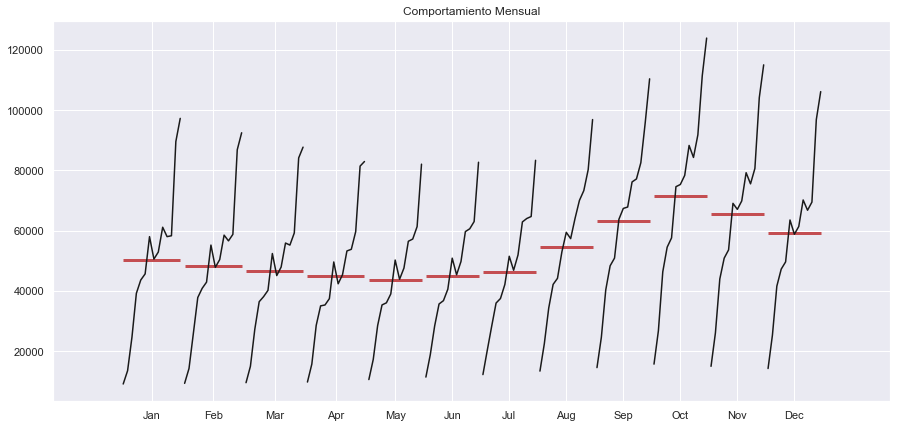

In [56]:
ax = plt.gca()
sm.graphics.tsa.month_plot(df_aapl['Ingresos'], ax=ax)
ax.set_title('Comportamiento Mensual')
# ax.figure.savefig('../pics/df_aapl/monthbehavior');

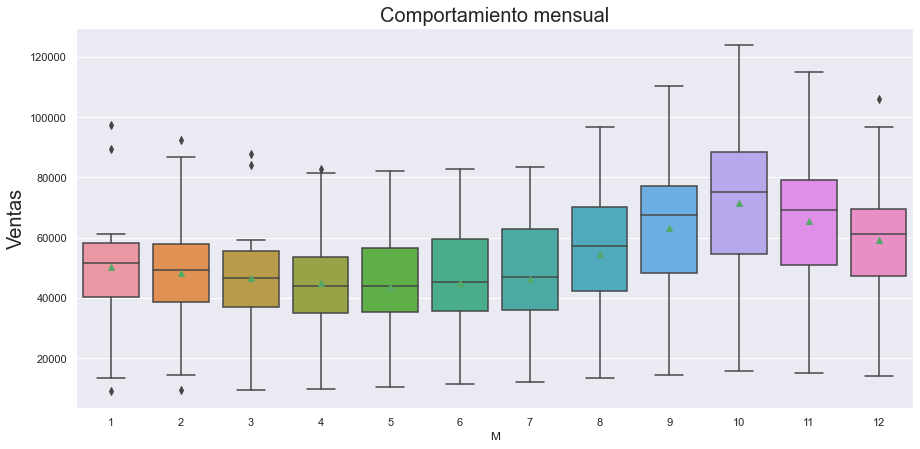

In [57]:
df_aapl['M'] = df_aapl.index.month
sns.boxplot(data = df_aapl, x = 'M', y='Ingresos', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Ventas', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 20);
# ax.figure.savefig('../pics/df_aapl/boxplotmonth');

Se aprecia que los meses de más venta son los correspondientes a los del cuarto trimestre. Esto es por el lanzamiento periódico de cada año en esas fechas del nuevo iPhone y otros productos de Apple, y también por las fechas navideñas. Esto nos indica una estacionalidad clara.

### 3.4) Descomposición

Y, por último, vamos a realizar la descomposición de la serie temporal del desempleo, que nos indica de un solo vistazo la estacionalidad, la tendencia y los residuos:

In [14]:
df_aapl.index = df_aapl.index.to_timestamp() # para corregir fallo del 
# Axis must have `freq` set to convert to Periods en el siguiente seasonal_decompose

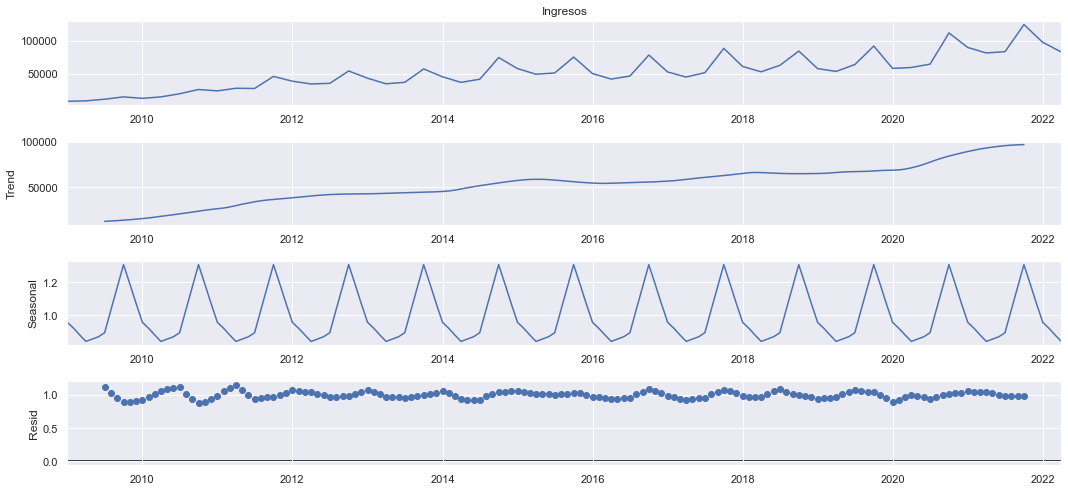

In [58]:
desglose = seasonal_decompose(df_aapl['Ingresos'], 
                              model='multiplicative',
                              period=12);
desglose.plot()
# plt.savefig("../pics/df_aapl/decompose.png");

Se observa entonces:

- Existe una **clara tendencia creciente positiva**.
- **Hay un componente estacional** en la que hay más ventas en el cuarto trimestre.
- La serie **no es estacionaria**.

## *4) Estimación mediante modelos*

### 4.1) Modelo de Suavizado Exponencial (ETS)
A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en el tiempo que ha habido desde el inicio de la pandemia, es decir, desde marzo del 2020. Como el dataset tiene datos hasta julio del 2022, hay 29 meses para el test_size.

Cantidad de períodos en Train: 131
Cantidad de períodos en Test: 29


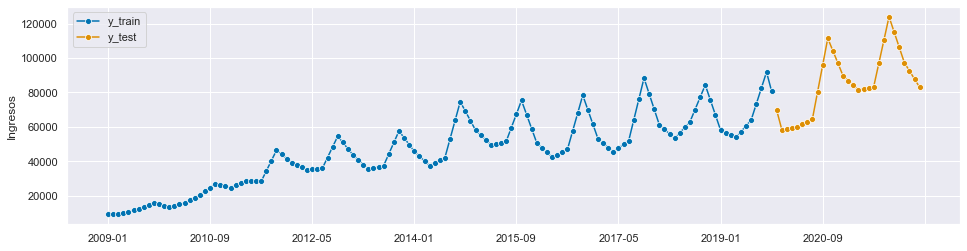

In [16]:
#Train-test
y_train,y_test=temporal_train_test_split(
    y=df_aapl['Ingresos'].astype('float64').to_period('M').sort_index(),test_size=29
)
# Grafico para representar la separación de los datos
plot_series(y_train, y_test, labels=["y_train","y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0])
plt.show()

In [17]:
y_test #observamos los 29 meses testeados

2019-12     69481.666667
2020-01     58313.000000
2020-02     58770.333333
2020-03     59227.666667
2020-04     59685.000000
2020-05     61356.000000
2020-06     63027.000000
2020-07     64698.000000
2020-08     80278.333333
2020-09     95858.666667
2020-10    111439.000000
2020-11    104154.000000
2020-12     96869.000000
2021-01     89584.000000
2021-02     86867.333333
2021-03     84150.666667
2021-04     81434.000000
2021-05     82076.000000
2021-06     82718.000000
2021-07     83360.000000
2021-08     96888.333333
2021-09    110416.666667
2021-10    123945.000000
2021-11    115056.000000
2021-12    106167.000000
2022-01     97278.000000
2022-02     92505.000000
2022-03     87732.000000
2022-04     82959.000000
Freq: M, Name: Ingresos, dtype: float64

In [18]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
aapl_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)

In [19]:
aapl_auto_ets.fit(y_train)
aapl_auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               Ingresos   No. Observations:                  131
Model:                      ETS(MAdM)   Log Likelihood               -1147.949
Date:                Mon, 29 Aug 2022   AIC                           2333.898
Time:                        17:38:11   BIC                           2388.526
Sample:                    01-31-2009   HQIC                          2356.096
                         - 11-30-2019   Scale                            0.001
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.180      5.549      0.000       0.647       1.353
smoothing_trend         0.5156      0.155      3.322      0.001       0.211       0.820
smoothing_seasonal   8.847e-05      0.075      0.001      0.999      -0.147       0.147
damping_trend           0.8000      0.136      5.885      0.000       0.534       1.066
initial_level        1.129e+04        nan        nan        nan         nan         nan
initial_trend         600.7389    598.075      1.004      0.315    -571.467    1772.945
initial_seasonal.0      1.1164        nan        nan        nan         nan         nan
initial_seasonal.1      1.2374        nan        nan        nan         nan         nan
initial_seasonal.2      1.3649        nan        nan        nan         nan         nan
initial_seasonal.3      1.2354        nan        nan        nan         nan         nan
initial_seasonal.4      1.0994        nan        nan        nan         nan         nan
initial_seasonal.5      0.9541        nan        nan        nan         nan         nan
initial_seasonal.6      0.9382        nan        nan        nan         nan         nan
initial_seasonal.7      0.9191        nan        nan        nan         nan         nan
initial_seasonal.8      0.8956        nan        nan        nan         nan         nan
initial_seasonal.9      0.9354        nan        nan        nan         nan         nan
initial_seasonal.10     0.9709        nan        nan        nan         nan         nan
initial_seasonal.11     1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                      101.48   Jarque-Bera (JB):               680.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [20]:
#step 5: querying predictions
aapl_pred = aapl_auto_ets.predict(fh=list(fh))
aapl_pred

2019-12    71916.482988
2020-01    63807.058258
2020-02    61479.424883
2020-03    58865.630034
2020-04    56085.518200
2020-05    57326.443453
2020-06    58333.733514
2020-07    59167.031112
2020-08    68042.033890
2020-09    76330.068118
2020-10    84220.161320
2020-11    76274.501131
2020-12    68758.089146
2021-01    61543.914706
2021-02    59721.566375
2021-03    57510.812188
2021-04    55047.722739
2021-05    56474.451934
2021-06    57637.943146
2021-07    58600.997382
2021-08    67520.211157
2021-09    75860.987790
2021-10    83805.559525
2021-11    75973.793909
2021-12    68541.045973
2022-01    61388.392665
2022-02    59600.767258
2022-03    57417.709815
2022-04    54976.405977
Freq: M, dtype: float64

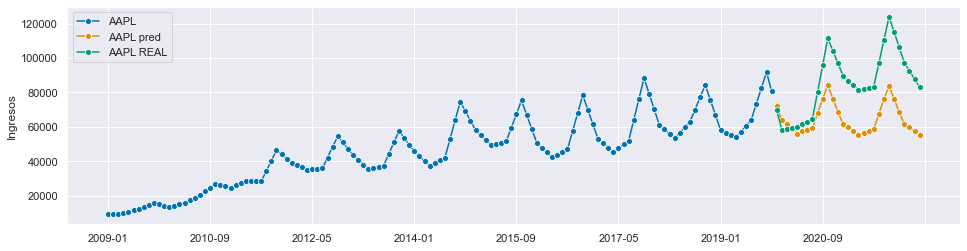

In [21]:
# optional: plotting predictions and past data
plot_series(y_train, aapl_pred, y_test, labels=["AAPL", "AAPL pred", "AAPL REAL"])
plt.show()

In [22]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test, aapl_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

El modelo ETS genera un RMSE de: 25240.21


In [23]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_ets = mape(y_test, aapl_pred)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un MAPE de: 23.6%


### 4.2. Modelo ARIMA

Al tratarse de una serie no estacionaria en media ni en varianza, debemos transformar a la serie para tener un correcto tratamiento de la misma y de esta manera, obtener las mejores predicciones posibles con el método de estimacion ARIMA.

Es necesario lograr que la serie sea estacionaria en varianza, luego el algoritmo es capaz de interpretar datos no estacionarios en media. Para ello, **aplicaremos logaritmo** y luego lo ploteamos para evidenciar si se ha logrado el objetivo.

In [24]:
transformer = LogTransformer()
log_df_aapl= transformer.fit_transform(df_aapl['Ingresos'])
log_df_aapl.tail()

Periodo
2021-12-01    11.572769
2022-01-01    11.485328
2022-02-01    11.435018
2022-03-01    11.382042
2022-04-01    11.326102
Freq: MS, dtype: float64

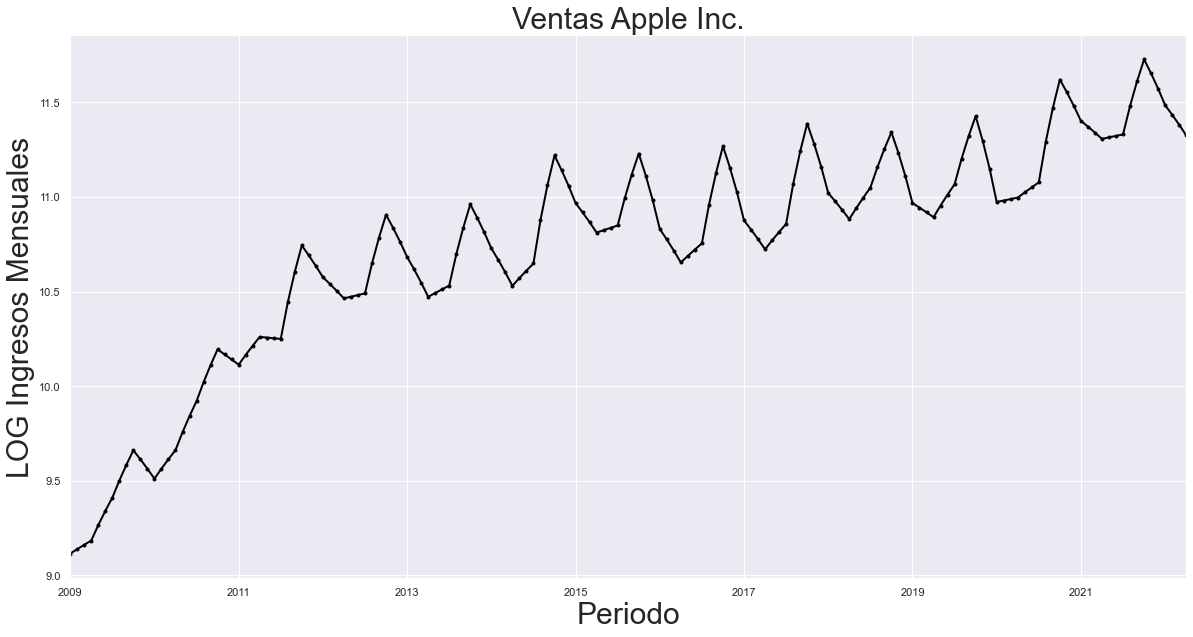

In [25]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = log_df_aapl.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Ventas Apple Inc.', fontsize = 30) 
fig.set_ylabel('LOG Ingresos Mensuales', fontsize = 30)
fig.set_xlabel('Periodo', fontsize = 30);

Separamos el train y el test a la serie transformada con logs:

131 29


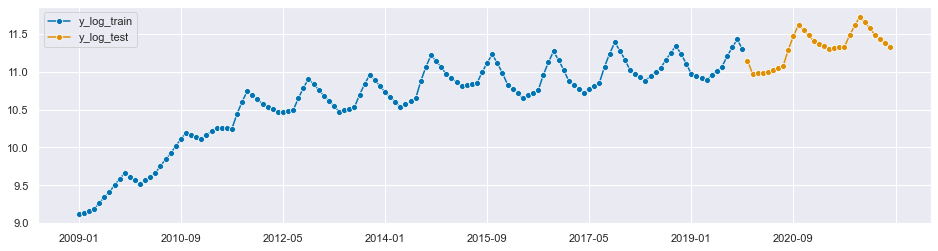

In [26]:
y_log_train,y_log_test=temporal_train_test_split(y=log_df_aapl.astype('float64').to_period('M').sort_index(),
                                                 test_size=29)
plot_series(y_log_train, y_log_test, labels=["y_log_train", "y_log_test"])
print(y_log_train.shape[0], y_log_test.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [27]:
fh = np.arange(1, y_log_test.shape[0]+1)
aapl_auto_arima=AutoARIMA(sp=12,suppress_warnings=True)

In [28]:
aapl_auto_arima.fit(y_log_train)
aapl_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  131
Model:             SARIMAX(0, 1, 2)x(2, 1, [1], 12)   Log Likelihood                 279.402
Date:                              Mon, 29 Aug 2022   AIC                           -546.803
Time:                                      17:40:26   BIC                           -530.179
Sample:                                           0   HQIC                          -540.053
                                              - 131                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7929      0.160      4.967      0.000       0.480       1.106
ma.L2          0.6950      0.070      9.910      0.000       0.558       0.832
ar.S.L12      -0.6524      0.286     -2.279      0.023      -1.214      -0.091
ar.S.L24      -0.3020      0.061     -4.925      0.000      -0.422      -0.182
ma.S.L12       0.4343      0.336      1.293      0.196      -0.224       1.093
sigma2         0.0005   4.04e-05     12.340      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               292.23
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
aapl_log_pred = aapl_auto_arima.predict(fh)
print(np.exp(aapl_log_pred))

2019-12    70076.730902
2020-01    59797.180357
2020-02    58115.232924
2020-03    56429.820205
2020-04    54740.716950
2020-05    58005.898097
2020-06    61265.910349
2020-07    64521.140569
2020-08    74723.320349
2020-09    84884.724673
2020-10    95020.439923
2020-11    83844.693503
2020-12    73148.722758
2021-01    62690.464556
2021-02    60732.040544
2021-03    58768.023279
2021-04    56797.834245
2021-05    60270.998209
2021-06    63742.162353
2021-07    67211.480545
2021-08    76603.889956
2021-09    85966.276898
2021-10    95308.775112
2021-11    84354.829546
2021-12    73781.537763
2022-01    63396.126338
2022-02    61619.963993
2022-03    59839.976199
2022-04    58055.800397
Freq: M, dtype: float64


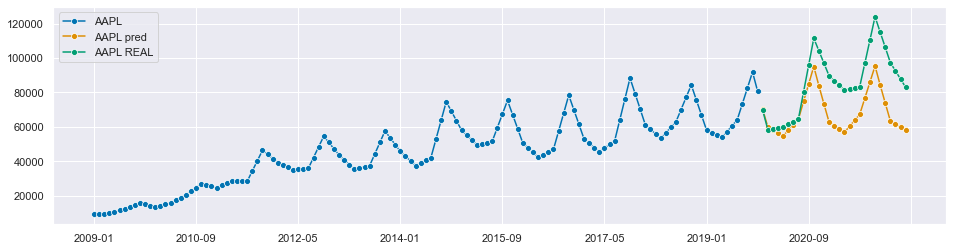

In [30]:
# representamos la serie predictiva
plot_series(np.exp(y_log_train), np.exp(aapl_log_pred), np.exp(y_log_test), labels=["AAPL", "AAPL pred", "AAPL REAL"])
plt.show()

In [31]:
mse = MeanSquaredError(square_root=True)
mse_log = mse(np.exp(y_log_test), np.exp(aapl_log_pred))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ARIMA genera un RMSE de: 20778.08


In [32]:
mape = MeanAbsolutePercentageError(symmetric=False)
mape_log = mape(np.exp(y_log_test), np.exp(aapl_log_pred))
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_log*100,2)))

El modelo ARIMA genera un MAPE de: 18.83%


#### Una comparativa entre ETS y ARIMA

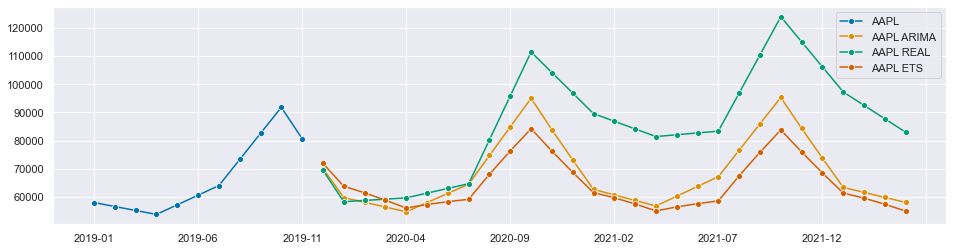

In [33]:
plot_series(np.exp(y_log_train["2019":]),
            np.exp(aapl_log_pred),
            np.exp(y_log_test),
            aapl_pred,
            labels=["AAPL","AAPL ARIMA","AAPL REAL","AAPL ETS"])
plt.show();
# plt.savefig('../pics/df_aapl/etsarima.png')

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [34]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))

El modelo ETS genera un RMSE de: 25240.21
El modelo ARIMA genera un RMSE de: 20778.08


2) MAPE (Error porcentual)

In [35]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))

El modelo ETS genera un MAPE de: 23.6%
El modelo ARIMA genera un MAPE de 18.83%


Confirmamos que el mejor modelo para este caso es ARIMA, ya que siempre buscamos minimizar el error.

### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 


Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [36]:
df_aapl=df_aapl.drop('M',axis=1)

In [37]:
prophet_train = df_aapl.reset_index() #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [38]:
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

131

In [39]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

29

In [40]:
prophet_y_train.round()

,ds,y
0,2009-01-31,9084.0
1,2009-02-28,9301.0
2,2009-03-31,9517.0
3,2009-04-30,9734.0
4,2009-05-31,10558.0
...,...,...
126,2019-07-31,64040.0
127,2019-08-31,73300.0
128,2019-09-30,82559.0
129,2019-10-31,91819.0


In [41]:
y_test.round()

2019-12     69482.0
2020-01     58313.0
2020-02     58770.0
2020-03     59228.0
2020-04     59685.0
2020-05     61356.0
2020-06     63027.0
2020-07     64698.0
2020-08     80278.0
2020-09     95859.0
2020-10    111439.0
2020-11    104154.0
2020-12     96869.0
2021-01     89584.0
2021-02     86867.0
2021-03     84151.0
2021-04     81434.0
2021-05     82076.0
2021-06     82718.0
2021-07     83360.0
2021-08     96888.0
2021-09    110417.0
2021-10    123945.0
2021-11    115056.0
2021-12    106167.0
2022-01     97278.0
2022-02     92505.0
2022-03     87732.0
2022-04     82959.0
Freq: M, Name: Ingresos, dtype: float64

In [42]:
m = Prophet()
m.fit(prophet_y_train)

17:40:27 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

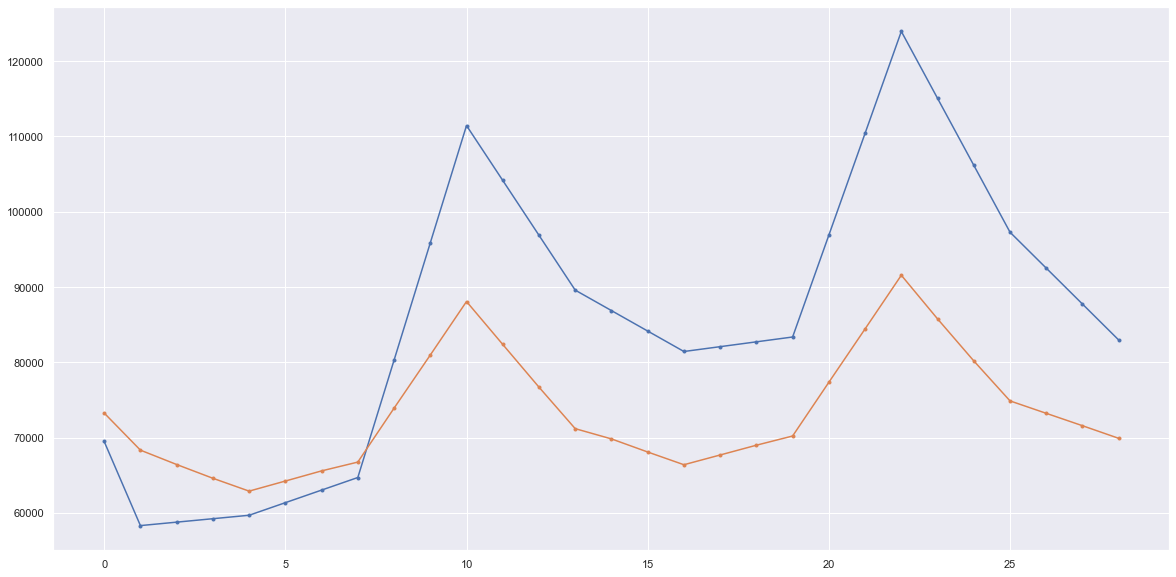

In [44]:
plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[131:, 'yhat']), '.-', label='Predicition')
plt.show()

In [45]:
# Forecast Accuracy
# MAPE
# mape_prophet = mean_absolute_percentage_error(prophet_y_test['y'], prophet_forecast.loc[47:, 'yhat'])
# mape_prophet

mape = MeanAbsolutePercentageError(symmetric=False)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[131:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

El modelo Prophet genera un MAPE de: 16.33%


In [46]:
# Forecast Accuracy
#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[131:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un RMSE de: 17166.59


In [47]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
155,2021-12-31,80188.0,73534.0,85960.0
156,2022-01-31,74873.0,68788.0,80973.0
157,2022-02-28,73223.0,66962.0,79237.0
158,2022-03-31,71577.0,65319.0,78130.0
159,2022-04-30,69901.0,64290.0,75924.0


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [48]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_log,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 25240.21
El modelo ARIMA genera un RMSE de: 20778.08
El modelo Prophet genera un RMSE de: 17166.59


2) MAPE (Error porcentual)

In [49]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_log*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 23.6%
El modelo ARIMA genera un MAPE de 18.83%
El modelo Prophet genera un MAPE de 16.33%


Confirmamos que **el mejor modelo para la predicción de esta serie temporal es la Prophet**, ya que es el que mejor se ajusta a los datos reales y es el que menor error da.

## *5) Predicción hasta finales de año*

In [50]:
prophet_train_log = np.log(df_aapl).reset_index()
prophet_train_log.columns = ['ds', 'y']

In [51]:
m_log = Prophet()
m_log.fit(prophet_train_log)

17:40:31 - cmdstanpy - INFO - Chain [1] start processing
17:40:31 - cmdstanpy - INFO - Chain [1] done processing


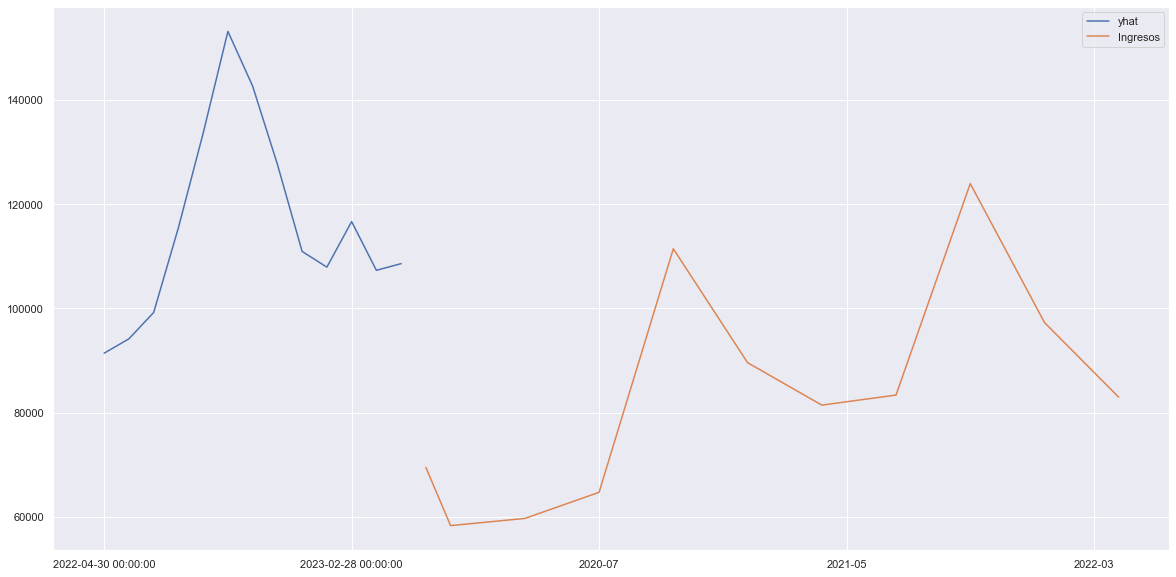

In [52]:
periods=13
future_log = m_log.make_future_dataframe(periods=periods, freq='M',include_history=True)
forecast_log = m_log.predict(future_log)
prophet_pred_log = forecast_log[['ds','yhat']].copy()
prophet_pred_log.set_index(['ds'], inplace=True)
prophet_pred_log = np.exp(prophet_pred_log)
pd.concat([prophet_pred_log.iloc[-periods:].astype('int'), y_test], axis=1).plot()
# plt.savefig(../pics/df_aapl/'predict2022.png')
plt.show();



            Ingresos
Periodo             
2021-12-01  106167.0
2022-01-01   97278.0
2022-02-01   92505.0
2022-03-01   87732.0
2022-04-01   82959.0



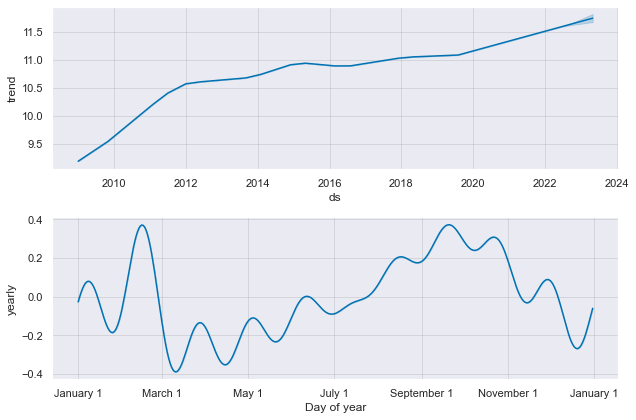

In [53]:
print('')
pred = prophet_pred_log.rename_axis(index=None).rename(columns={
    'yhat': 'Ingresos'}).iloc[-periods:].astype('int')
df_aapl2 = df_aapl.append(pred)
print(df_aapl.tail())
print('')

fig2 = m_log.plot_components(forecast_log)
plt.show();